# Lecture 2, Data science in Neuroscience

## Plan for today

1. Review of last week's exercises
2. Why and how are in-vivo recordings performed?
3. Detecting action potentials (spikes) from raw extracellular recordings and spike clustering
    * Filtering out unwanted frequencies from signals
    * Detecting spike events in the filtered signals
    * Extracting spike waveforms from raw signals (next week)
    * Dimensionality reduction of spike waveforms (next week)
    * Clustering spike waveforms (next week)

***

## Review of last week's exercises

Reload the data from last week.

The is a recording from 8 electrodes/channels for 1 second at 20 000 Hz.


After completing the exercises, you should now know that the array looks like the one in this figure.
<div>
<img src="../images/array.png" width="600"/>
</div>



In [1]:
import numpy as np
import matplotlib.pyplot as plt

fileName = "../data/shortRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)

* What do you think the electrodes are measuring? 
* How many dimensions does the data have?
* What is the size of the array in each dimension?
* What is the data type or dtype (integer, float, etc.) of the `dat` array?
* Which dimension represents the recording channels and the recording samples?

* Plot the data for the first recording channel.
* Do you seen any oscillatory patterns in the data? If so at which frequency? 
* Plot the data for 2 recording channels. 
* What is similar or different between the different channels?

* What is the mean value in the `dat` array?
* What is the mean value per channel of the `dat` array?
* Can you plot the mean value across channels for all samples? The plot should have 20000 values.
* How could I add 100 to all values in the array?
* Which channel has the largest standard deviation?
* Can you plot the distribution of values for the second recording channel?
* For each channel, remove the mean from every data point.


***

# Why and how are in-vivo recordings performed?

**Aim:** Monitor the activity of groups of neurons during behavior. 

The correlations between cell activity and behavior inform us about the potential role of a brain area for behavior. We can learn how information is processed within neuronal circuits. The effect of different manipulations (optogenetics, pharmacology) on network activity can be assessed.

## Example: Spatially selective neurons in the medial entorhinal cortex (MEC)

By recording the activity of neurons in the entorhinal cortex in freely-moving mice, scientists discovered that MEC neurons encode where the animal is in its environment and in which direction it is heading. This brain region is essential for navigation.


<div>
<img src="../images/mec_neurons.png" width="400"/>
</div>

* Right column: Spikes (red) on top of the path of the animal (black).
* Left column: Firing rate of the neuron as a function of position (top), head-direction (middle) and running speed (bottom). 


<div>
<img src="../images/Nobel.jpg" width="400"/>
</div>
These 3 fellows won the Nobel Prize for their discovery of place and grid cells.



### References
* Hafting et al., 2005. Microstructure of a spatial map in the entorhinal cortex. Nature
* Sargolini et al., 2006. Conjunctive Representation of Position, Direction, and Velocity in Entorhinal Cortex. Nature
* Gil et al., 2018. Impaired path integration in mice with disrupted grid cell firing. Nature Neuroscience

## Electrodes -> Amplifier -> Digitalization -> Recording on disk

Electrodes located in the extracellular space can pick up action potentials (sharp negative fluctuation in voltage) from several neurons. 

<div>
<img src="../images/buzsaki_tetrode_in_layer.jpg" width="600"/>
</div>


<div>
<img src="../images/buzsaki_probe.webp" width="800"/>
</div>

<div>
<img src="../images/intan_64.jpg" width="300"/>
</div>


### References
* Buzsaki, 2004. Large-scale recording of neuronal ensembles. Nature Neuroscience
* Steinmetz et al., 2021. Neuropixels 2.0: A miniaturized high-density probe for stable, long-term brain recordings. Science
* https://intantech.com/


The recording system sample the voltage on multiple channels at 20-30 kHz. The amplified signal is saved to disk for later analysis.

***

# Spike extraction and clustering


We want to study the activity (action potentials) of single neurons. We need to find at which time which neurons fired action potentials from our raw recordings. 

Assumptions:
1. All the spikes from one neuron will have a constant waveform shape on the different channels. The pattern across the different channels depend on the proximity of the neuron to the different electrodes (channels).
2. The spike waveform of different neurons will be different because of their different locations relative to the recording sites.

Let's have a look at our data.

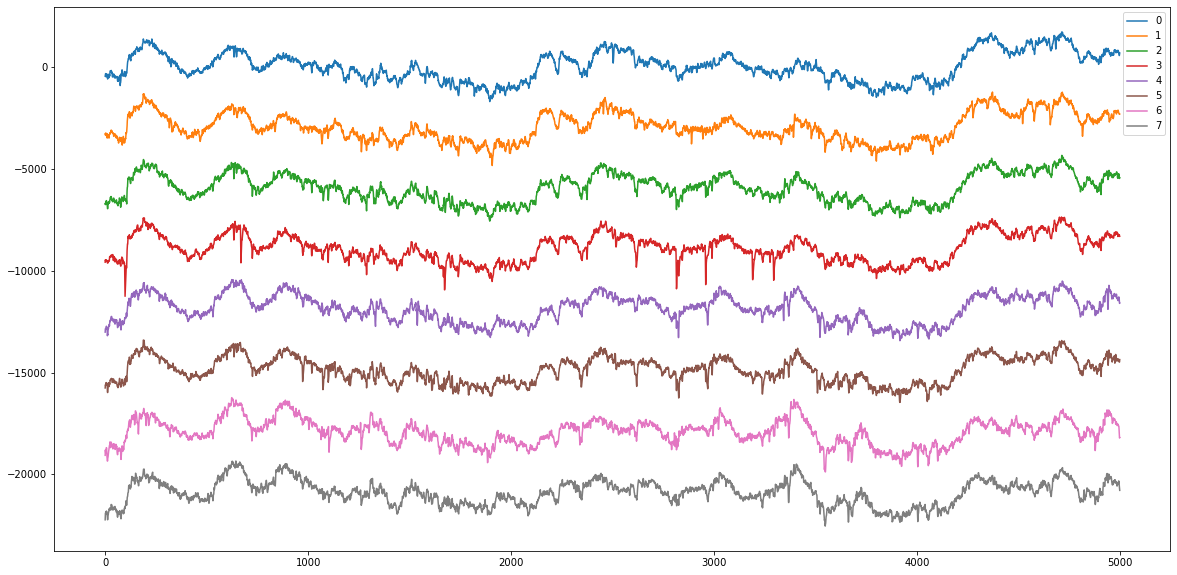

In [2]:
offset=3000 #y-shift between channels when plotting the data
nSamples=5000
plt.figure(figsize=(20,10)) # set the size of the figure

for i in range(dat.shape[0]): #loop for every channel
    plt.plot(dat[i,:nSamples]-i*3000,label=i) # plot the channel, apply the y-offset so that the channels are not all on top of each other
plt.legend()
plt.show()

## Steps involved
* Filtering
* Identifying spikes
* Extracting spike waveforms
* Dimensionality reduction
* Clustering spike waveforms

Note: In the lab, you would normally use an established software package to do this (Kilosort, Spyking circus, etc.).

Many classic data processing steps are involved.

*** 
## Filtering

The signal recorded is the sum of several components: 

1. Large amplitude spikes of a few neurons close to the recording sites
2. Small amplitude spikes of many distant neurons
3. Fluctuations in synaptic currents onto thousands of neurons (part of local field potentials)
4. Electrical noise from electrical equipment (usually 50 Hz)
5. Head muscle contractions (e.g., noise associated with chewing)
6. Motion artifacts

If a neuron is close enough to our electrodes, its action potentials create rapid (usually) negative deflections in the signal. The spikes in extracellular space last less than 1 ms.

To extract action potentials, we need to separate these fast negative deflections from other slower components of the signal. That is why we need to filter the signal.

https://docs.scipy.org/doc/scipy/reference/signal.html

https://docs.scipy.org/doc/scipy/tutorial/signal.html


### Create a Butterworth filter

We eliminate/reduce low-frequency oscillations (below 300 Hz) and keep faster oscillations (including spikes). This is called a `highpass filter` (as opposed to lowpass and bandpass).



In [3]:
from scipy.signal import butter

In [4]:
fs = 20000 # sampling rate

In [5]:
def create_butter_highpass_filter(lowcut, fs, order=3):
    """
    Create a Butterworth filter using scipy.signal.butter()
    
    Arguments:
    lowcut: low cut frequency
    fs: sampling rate in Hz
    order: order of the fitler
    
    Returns
    Second-order sections representation of the IIR filter. 
    
    For more information, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
    """
    nyq = 0.5 * fs # Nyquist frequency (sampling rate/2)
    low = lowcut / nyq # lowcut as a proportion of Nyquist frequency
    sos = butter(order, [low], btype='highpass' ,  output='sos') #‘sos’ should be used for general-purpose filtering.
    return sos


In [6]:
lowcut=300
myFilter = create_butter_highpass_filter(lowcut = lowcut,fs=fs, order=3)

### Display the frequency response of the filter

It should be near 0 and flat at the frequencies that you want to keep, and below 0 for frequencies that you want to filter out.

In [7]:
# calculate the frequency response of our filter for visualization
from scipy.signal import sosfreqz
w, h = sosfreqz(myFilter, worN=1500)

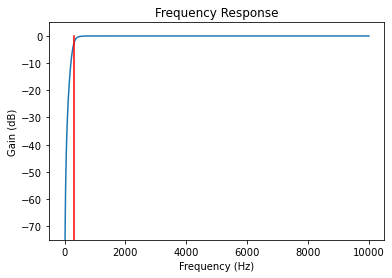

In [8]:
db = 20*np.log10(np.maximum(np.abs(h), 1e-5)) # don't worry about this, transforms h to dB unit
plt.plot(w/np.pi*fs/2, db) # first part transform w to in Hz unit
plt.ylim(-75, 5)
plt.ylabel('Gain (dB)')
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Response')
plt.plot([lowcut,lowcut],[-75,0],c="red")
plt.show()

## Apply the fitler to a recording channel

We can apply our filter with `sosfiltfilt()`

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfiltfilt.html

See also https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter

In [9]:
from scipy.signal import sosfiltfilt
chan=3
y = sosfiltfilt(myFilter, dat[chan,:]) # we filter the raw data from channel 3 and save the results in y
print(y.shape, dat[chan,:].shape) # y has same shape as the raw data from channel 3

(20000,) (20000,)


Plot the raw and filtered signals

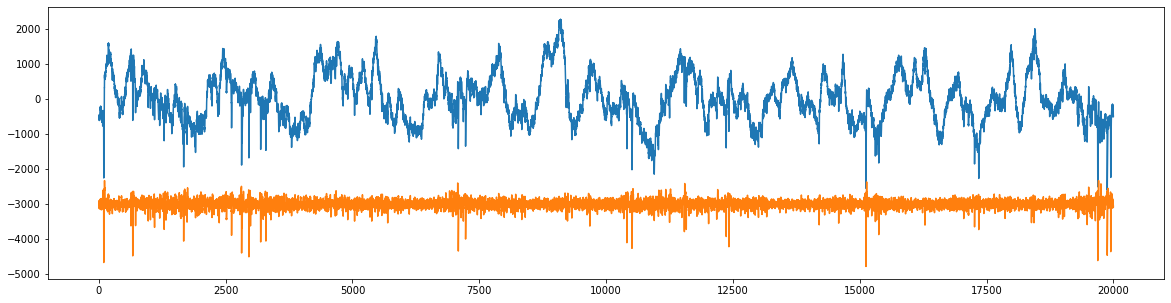

In [10]:
nSamples=20000
plt.figure(figsize=(20,5))
plt.plot(dat[chan,0:nSamples])
plt.plot(y[0:nSamples]-3000)
plt.show()

Plot fewer data points to zoom in on the raw and filtered signals. 

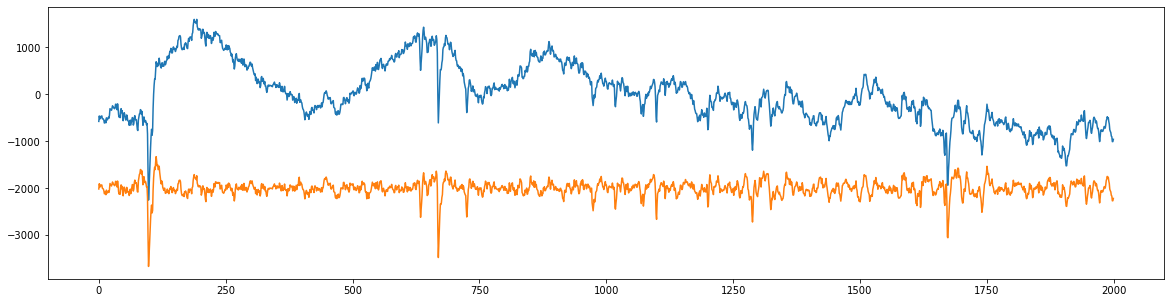

In [11]:
nSamples=2000
plt.figure(figsize=(20,5))
plt.plot(dat[chan,:0+nSamples])
plt.plot(y[:0+nSamples]-2000)

## Exercises: 

* Try to apply the filter to the 8 recording channels. 
* How could you store/save the filtered data for each channel.



In [12]:
y = sosfiltfilt(myFilter, dat)

In [13]:
filtDat = np.empty_like(dat)
for chan in range(dat.shape[0]):
    filtDat[chan,:] = sosfiltfilt(myFilter, dat[chan,:])
filtDat.shape

(8, 20000)

As always, don't just assume that the filter was applied to all channels, plot the data to be sure.

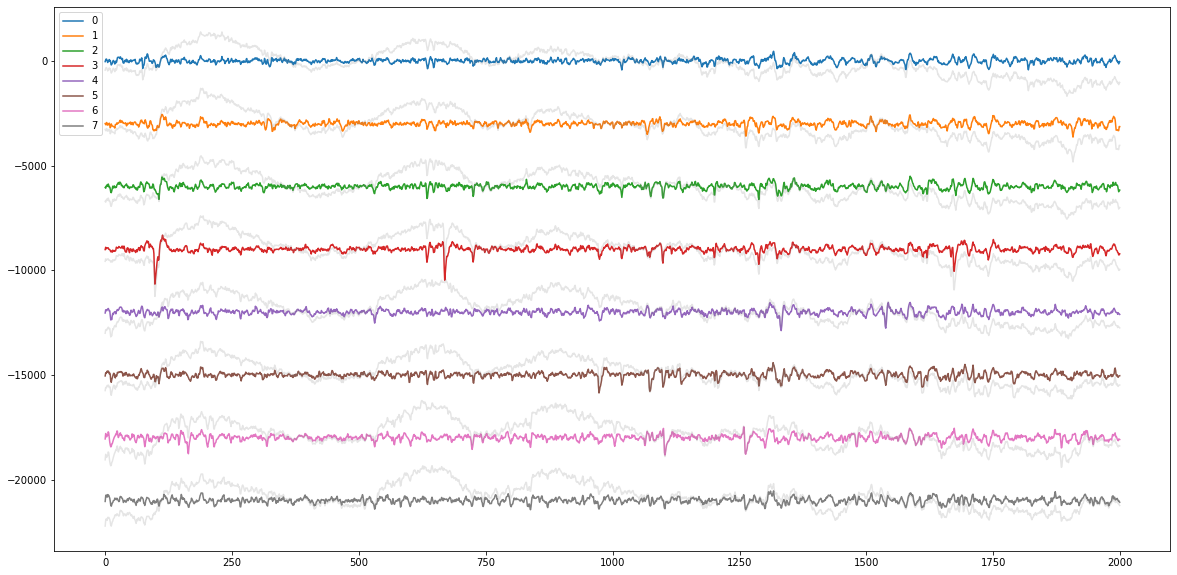

In [14]:
offset=3000 #y shift on the y-axis between channels
nSamples=2000
plt.figure(figsize=(20,10))

for i in range(y.shape[0]): #loop for every channel
    yAxisOffset=i*offset # to avoid plotting all channels on top of each other, channel 0 will be at the top
    plt.plot(y[i,:nSamples]-yAxisOffset,label=i,alpha=1) # plot the filtered data
    plt.plot(dat[i,:nSamples]-yAxisOffset,c="gray",alpha=0.2) # plot original signal in transparent gray
plt.legend(loc="upper left")
plt.show()

***
## Detecting spikes

We have removed slow owcillations from the raw signal. We can try to identify spikes in the filtered signal.

One simple strategy is to calculate the **mean** and **standard deviation** of the filtered signal. A spike occures each time the signal reaches 5 standard deviation below the mean. This is the __spike detection threshold__.


Steps:

* Calculate mean and standard deviation
* Calculate the spike detection threshold
* Detect the events that reached the spike detection threshold

### Calculating the mean and standard deviation

We will use a single channel (chan=3) to simplify the problem.


### Exercise

* Calculate and print the mean and standard deviation of channel indexed 3

In [15]:
chan=3
mean = y[chan,:].mean()
myStd = y[chan,:].std()

* Calculate the spike detection threshold

In [16]:
threshold = mean-5*myStd

Plot the data to check if this makes sense.

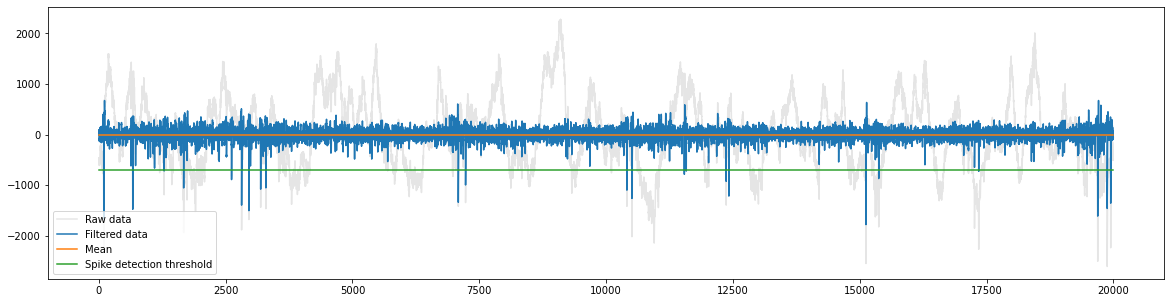

In [17]:
plt.figure(figsize=(20,5))
plt.plot(dat[chan,:],label="Raw data",c="gray", alpha=0.2)
plt.plot(y[chan,:],label="Filtered data")
plt.plot([0,y.shape[1]],[mean,mean], label="Mean")
plt.plot([0,y.shape[1]],[threshold,threshold], label="Spike detection threshold")
plt.legend()
#fn = "../images/spikeDetection.png" # You can save a png file with the plot.
#plt.savefig(fn)
plt.show()

We can zoom in by plotting only the first 1000 samples.

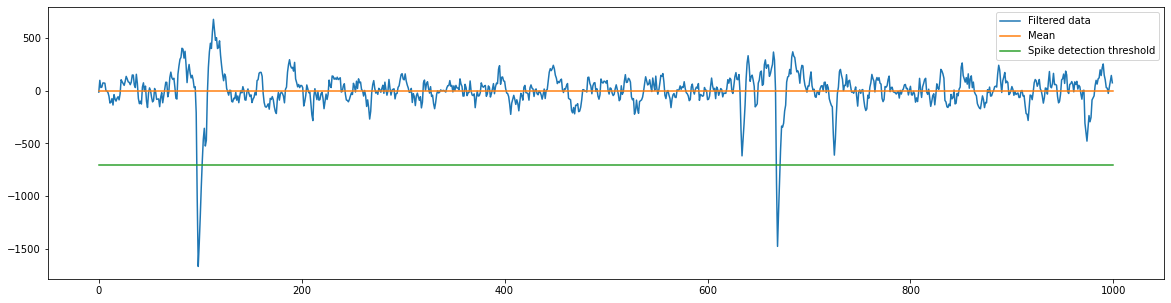

In [18]:
nSamples=1000
plt.figure(figsize=(20,5))
plt.plot(y[chan,:nSamples],label="Filtered data")
plt.plot([0,nSamples],[mean,mean],label="Mean")
plt.plot([0,nSamples],[threshold,threshold],label="Spike detection threshold")
plt.legend()
plt.show()

### Detect events that reached the spike detection threshold

We now need to find the trough of the detected spikes. 

Detecting spikes in our signal is a specific example of finding local peaks into a signal. 


Here is how I would approach this problem:

* Investigate whether there is a function already available to help you. Try googling `python find peaks`.

We can use [scipy.signal.find_peaks()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) to detect local peaks in our signal.

This function is looking for peaks, not for troughs (negative peaks). We therefore first need to invert our signal so that the spikes have positive peaks.

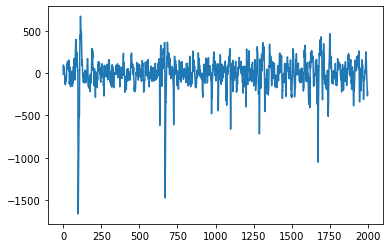

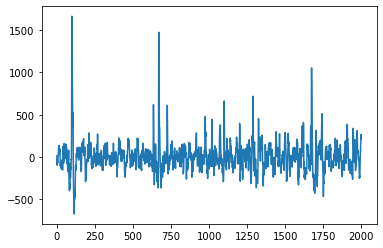

In [19]:
nSamples=2000

## important point about np.arrays
yDetect = y[chan,:].copy() # use a copy of the data to avoid destroying it during the manipulation

plt.plot(yDetect[0:nSamples])
plt.show()

# invert the signal to get positive peaks
yDetect = 0 - yDetect # inverse 
plt.plot(yDetect[0:nSamples])
plt.show()

[`scipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) can identify the time of the peaks (spikes) for us.

In [20]:
from scipy.signal import find_peaks
spikeTimes, _ = find_peaks(x=yDetect,height=0-threshold) # the function returs 2 values, we want the first one
print("Number of detected spikes:",spikeTimes.shape[0])

Number of detected spikes: 23


We plot the filtered signal with the detected spike times. Always plot the results to make sure you get what you expect.

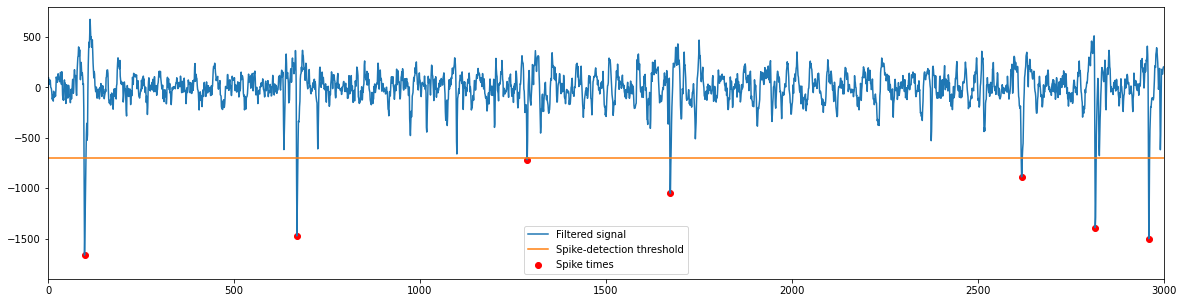

In [21]:
chan=3 # select a channel to work with
nSamples=3000
plt.figure(figsize=(20,5))
plt.plot(y[chan,:nSamples],label="Filtered signal")
plt.scatter(spikeTimes,y[chan,spikeTimes],c="red",label="Spike times")
plt.plot([0,nSamples],[threshold,threshold],label="Spike-detection threshold") 
plt.xlim(0,nSamples)
plt.legend()
plt.show()

The negative spikes crossing the spike-detection threshold are identified correctly by the find_peaks() function.

# Homework

1. Write the code that would apply our spike detection procedure to the 8 recording channels in our data? 
    * You could try to use a `for` loops to loop across the channels. Within this loop, you can reuse the code that we used above.
    * You could store the spike times array in a list of array.
    
   
2. Try to plot the data from all channels with their threshold and detected spikes. This would confirm that your spike detection worked.


***
# Summary

After going through Weeks 1 and 2, you should

* Be able to filter raw signals using SciPy.
* Becoming familiar with manipulating NumPy arrays (slicing, using methods like .mean(), .std(), broadcasting, etc.).
* Know that anyone doing data science should be plotting data all the time.
